<a href="https://colab.research.google.com/github/sharon-kurant/VCE_Remission_Classification/blob/main/stills_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import pathlib
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [3]:
STILLS_PATH = "/content/drive/MyDrive/remission/stills/"
DATASETS_PATH = "/content/drive/MyDrive/remission/stills/New data/"
SAVE_MODEL_PATH = "/content/drive/MyDrive/remission/stills/models"

In [4]:
arguments = {
             "dataset": DATASETS_PATH,
             "save_model_path": SAVE_MODEL_PATH + os.sep + 'finetuned_hybrid_data_no_aug', #None will not save the model
             "training_layers": 0, # Last layers to train in Resnet, -1 is to freeze all
             "network": 'resnet', # efficient, mobile...
             "epochs": 3,
             "batch_size": 16,
             "image_size": (500,500),
             "test": True,
             "test_path": ''
            }

In [5]:
dataset = arguments["dataset"]
save_model_path = arguments["save_model_path"]
training_layers = arguments["training_layers"]
network = arguments["network"]
epochs = arguments["epochs"]
batch_size = arguments["batch_size"]
image_size = arguments["image_size"]
test = arguments["test"]
test_path = arguments['test_path']

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  labels = "inferred",
  image_size= image_size,
  batch_size = batch_size,
  crop_to_aspect_ratio = True)

Found 15744 files belonging to 4 classes.
Using 12596 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  labels = "inferred",
  image_size=image_size,
  batch_size=batch_size,
  crop_to_aspect_ratio = True)

Found 15744 files belonging to 4 classes.
Using 3148 files for validation.


In [8]:
model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
                  include_top=False,
                  weights='imagenet',
                  input_shape=(image_size[0],image_size[1],3),
                  pooling='avg',
                  classes=2)

# for layer in pretrained_model.layers:
#   layer.trainable=False

model.add(pretrained_model)

model.add(Flatten())
## Get features from the tsne and then add more layers

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

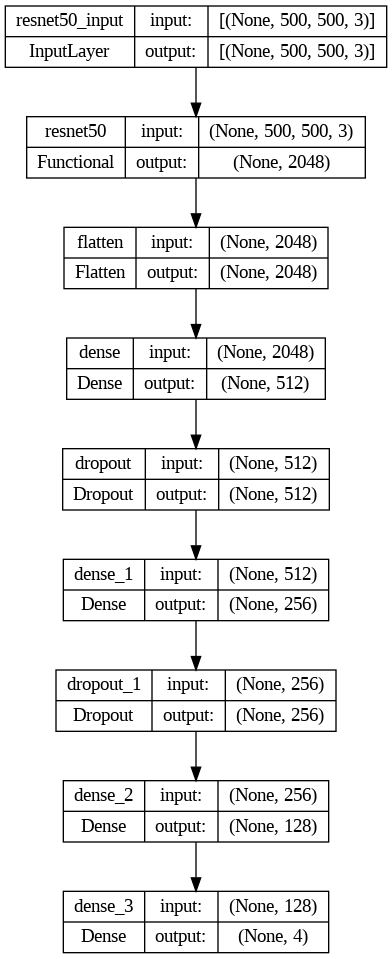

In [9]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# class_weight = {0:4, 1:1}
history = model.fit(x=train_ds,validation_data=val_ds, epochs=epochs)

Epoch 1/3
788/788 [==============================] - 861s 1s/step - loss: 0.6934 - accuracy: 0.7425 - val_loss: 1.1122 - val_accuracy: 0.7668
Epoch 2/3
788/788 [==============================] - 239s 302ms/step - loss: 0.4462 - accuracy: 0.8331 - val_loss: 0.4875 - val_accuracy: 0.8056
Epoch 3/3
788/788 [==============================] - 237s 301ms/step - loss: 0.3569 - accuracy: 0.8665 - val_loss: 0.4344 - val_accuracy: 0.8180


In [12]:
model_plain = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
                  include_top=False,
                  weights=None,
                  input_shape=(image_size[0],image_size[1],3),
                  pooling='avg',
                  classes=2)

# for layer in pretrained_model.layers:
#   layer.trainable=False

model_plain.add(pretrained_model)

model_plain.add(Flatten())
## Get features from the tsne and then add more layers

model_plain.add(Dense(512, activation='relu'))
model_plain.add(Dropout(0.4))
model_plain.add(Dense(256, activation='relu'))
model_plain.add(Dropout(0.3))
model_plain.add(Dense(128, activation='relu'))
model_plain.add(Dense(4, activation='softmax'))

In [14]:
model_plain.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# class_weight = {0:4, 1:1}
history = model_plain.fit(x=train_ds,validation_data=val_ds, epochs=10)

Epoch 1/10
788/788 [==============================] - 276s 304ms/step - loss: 0.7260 - accuracy: 0.7182 - val_loss: 0.8441 - val_accuracy: 0.6912
Epoch 2/10
788/788 [==============================] - 235s 297ms/step - loss: 0.6840 - accuracy: 0.7332 - val_loss: 0.7194 - val_accuracy: 0.7173
Epoch 3/10
788/788 [==============================] - 237s 299ms/step - loss: 0.6332 - accuracy: 0.7591 - val_loss: 0.7539 - val_accuracy: 0.7132
Epoch 4/10
788/788 [==============================] - 249s 315ms/step - loss: 0.5772 - accuracy: 0.7806 - val_loss: 0.8166 - val_accuracy: 0.7138
Epoch 5/10
788/788 [==============================] - 236s 299ms/step - loss: 0.5158 - accuracy: 0.8010 - val_loss: 0.5855 - val_accuracy: 0.7859
Epoch 6/10
788/788 [==============================] - 235s 297ms/step - loss: 0.4656 - accuracy: 0.8209 - val_loss: 1.5552 - val_accuracy: 0.5451
Epoch 7/10
788/788 [==============================] - 232s 294ms/step - loss: 0.4128 - accuracy: 0.8432 - val_loss: 0.4536 -